# Time series classification for rumor detection 
## - Codes and data
### Weiss, F., Mendoza, M. and Milios, E., 2020
### mailto: marcelo.mendoza@usm.cl

# Data preprocessing

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1319]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw, dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

import get_time_series 

In [1320]:
dest = 'twitter16' #chante to twitter15 for Twitter 15 dataset acq

class data_process:
    def __init__(self, path = dest):
        self.news = get_time_series.load_data(path = path)
        self.posts = get_time_series.load_data_posts(path = path)
        self.users = get_time_series.load_data_users(path = path)


In [1321]:
def ts_div_time_interactions(news, time, window, sliding_window):
    nodes_order = news.tree.nodes_order
    freq_ret, freq_rep, tic = ([] for i in range(3))
    if sliding_window:
        step = 1
    else: 
        step = window
    for i in np.arange(news.tree.first_time, news.tree.first_time + time, step): # interval lim inf 
            f_ret = 0
            f_rep = 0
            j = 0
            while j<len(nodes_order):
                if round(i,2) <= nodes_order[j].timestamp and nodes_order[j].timestamp <= round(i+window,2):
                    if nodes_order[j].retweet:
                        f_ret += 1       
                    else:
                        f_rep += 1
                j +=1      
            freq_ret.append(f_ret)
            freq_rep.append(f_rep)
            tic.append(i)
            
    return np.array(tic), np.array(freq_ret), np.array(freq_rep)


In [1322]:
def get_interactions(news_dict, window, sliding_window, time):
    label_to_idx = {'true': 0, 'non-rumor': 1, 'unverified': 2, 'false': 3}
    retweets, posts, labels = ([] for i in range(3))
    for id_ in news_dict.keys():
        x, y_ret, y_rep = ts_div_time_interactions(news_dict[id_], time, window, sliding_window)
        labels.append(label_to_idx[news_dict[id_].label]) 
        retweets.append(y_ret)
        posts.append(y_rep)
    
    return np.array(labels), np.array(retweets), np.array(posts)

In [5]:
data = data_process(dest)

In [6]:
labels, retweets, posts = get_interactions(data.news, 10, True, 720)
interactions = retweets + posts
grad_interactions_1 = np.gradient(interactions, axis=1)
grad_interactions_2 = np.gradient(grad_interactions_1, axis=1)

In [1348]:
def get_multivariate_series(time_series, labels, scale = 1): 
        paa = PiecewiseAggregateApproximation(n_segments=140) # equals the number of segments and samples!!!
        digits = []
        for i in range(72):
            digits.append(i*10)
        digits = np.array(digits)
        
        if scale == 0:
            time_series_scaled = []
            for ts in time_series:
                scaler = MinMaxScaler()
                scaler.fit(ts)
                ts = scaler.transform(ts)
                ts = ts.reshape(ts.shape[0],ts.shape[1])
                time_series_scaled.append(ts)
        elif scale == 1:
            time_series_scaled = []
            for ts in time_series:
                scaler = MinMaxScaler()
                scaler.fit(ts)
                ts = scaler.transform(ts)
                ts = paa.inverse_transform(paa.fit_transform(ts))
                ts = ts[:,digits,:]
                ts = ts.reshape(ts.shape[0],ts.shape[1])
                time_series_scaled.append(ts)
                
        time_series_multi = np.stack(time_series_scaled, axis=-1) # -1
        return time_series_multi


In [1349]:
time_series = get_multivariate_series(time_series=[retweets, posts, interactions, grad_interactions_1, grad_interactions_2], labels=labels, scale=1)
x_train, x_test, y_train, y_test = train_test_split(time_series, labels, test_size=0.2, stratify=labels)

In [1350]:
x_train.shape

(654, 72, 5)

In [1351]:
np.where(y_train == 3)[0].shape[0]

164

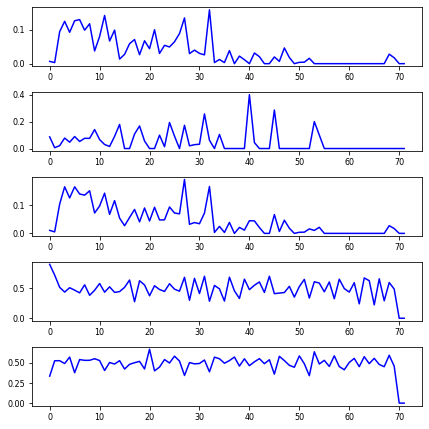

In [1352]:
plt.rcParams["figure.figsize"] = (6,6)
plt.figure()
plt.subplot(5,1,1)
plt.plot(time_series[0,:,0].ravel(), "b-")
plt.subplot(5,1,2)
plt.plot(time_series[0,:,1].ravel(), "b-")
plt.subplot(5,1,3)
plt.plot(time_series[0,:,2].ravel(), "b-")
plt.subplot(5,1,4)
plt.plot(time_series[0,:,3].ravel(), "b-")
plt.subplot(5,1,5)
plt.plot(time_series[0,:,4].ravel(), "b-")
plt.tight_layout()
plt.show()

# Prototype-based clustering

In [1353]:
def confusion_matrix(y_train,y_clus,n_prototypes):
    n_classes = np.unique(y_train).shape[0]
    conf = np.zeros((n_classes,n_prototypes), dtype=int)
    n_instances = y_clus.shape[0]
    for k in range(n_instances):
        i = y_train[k]
        j = y_clus[k]
        conf[i][j] += 1
    
    return conf

In [1354]:
def gini_coefficient(conf):
    n_classes = conf.shape[0]
    n_prototypes = conf.shape[1]
    gini = np.zeros(n_prototypes, dtype=float)
    for j in range(n_prototypes):
        acc = float(conf[:,j].sum())
        if acc > 0:
            for i in range(n_classes):
                ratio = float(conf[i,j])/acc
                gini[j] += pow(ratio, 2)
            gini[j] = round(1 - gini[j], 3)
        else:
            gini[j] = np.nan
        
    return gini

In [1355]:
def k_clustering(x_train,fe):
    n_prototypes = 20
    n_instances = x_train.shape[0]
    km_dba = TimeSeriesKMeans(n_clusters=n_prototypes, metric="dtw", init="k-means++")
    y_clus = km_dba.fit_predict(x_train[:,:,fe])
    return km_dba, y_clus

In [1356]:
km_dba_0, y_clus_0 = k_clustering(x_train,0)
km_dba_1, y_clus_1 = k_clustering(x_train,1) 
km_dba_2, y_clus_2 = k_clustering(x_train,2) 
km_dba_3, y_clus_3 = k_clustering(x_train,3) 
km_dba_4, y_clus_4 = k_clustering(x_train,4) 

In [1357]:
conf_0 = confusion_matrix(y_train,y_clus_0,20)
conf_1 = confusion_matrix(y_train,y_clus_1,20)
conf_2 = confusion_matrix(y_train,y_clus_2,20)
conf_3 = confusion_matrix(y_train,y_clus_3,20)
conf_4 = confusion_matrix(y_train,y_clus_4,20)

In [1358]:
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [1359]:
matprint(conf_0)

 3  111  0   6  0  1  0  20  1  0  1  2  0  1  1  0  0  16  2   0  
12   62  0  18  1  0  0  27  6  0  1  2  1  0  0  0  3  25  0   6  
 4   97  0   4  1  0  1   1  1  1  0  0  2  0  0  0  0  41  0   8  
 1   93  1   3  0  0  0   3  3  0  1  1  3  0  0  2  2  39  1  11  


In [1360]:
matprint(conf_1)

117  0  23  0  0  0  0  0  0  0   0  0  14  0   6  3  2  0  0  0  
 61  1  25  5  0  1  0  2  1  1  18  1  31  1  14  0  1  1  0  0  
 70  0  44  1  1  0  1  0  0  0   4  0  16  0  16  1  4  1  0  2  
 89  0  30  0  0  0  0  0  0  0   1  0  15  0  21  3  4  0  1  0  


In [1361]:
matprint(conf_2)

 1  27   2  0  0  1  1  12  0  1  1  0   6  94  2  0   7   8  2  0  
 8  65  15  0  0  1  2   9  0  5  1  2  23  13  1  0  10   8  1  0  
10  17  10  1  0  0  0   2  0  2  0  1   0  73  0  1  10  33  0  1  
11  35   6  0  1  0  0   1  1  3  1  1   4  66  1  0   7  25  1  0  


In [1362]:
matprint(conf_3)

28  0  0  0   7  0  0  1  0  0  1  0  0  103  0  22  2  0  1  0  
37  0  0  1  10  0  2  0  1  0  0  1  1   54  0  55  1  1  0  0  
44  0  0  0   2  1  1  0  0  1  0  0  1   97  0  14  0  0  0  0  
42  1  1  0   3  0  1  0  2  0  0  0  0   92  1  20  0  0  0  1  


In [1363]:
matprint(conf_4)

3  36  0  0   4   84  0  34  0  2  0  1  0  0  0  0  1  0  0  0  
5  22  1  1  12   79  0  36  0  1  0  0  1  1  0  1  2  1  1  0  
1   8  0  1   3  115  0  26  1  0  0  2  0  0  0  1  2  0  0  1  
4   9  0  3   2  115  1  24  0  1  1  2  0  0  1  0  1  0  0  0  


In [1364]:
gini_0 = gini_coefficient(conf_0)
gini_1 = gini_coefficient(conf_1)
gini_2 = gini_coefficient(conf_2)
gini_3 = gini_coefficient(conf_3)
gini_4 = gini_coefficient(conf_4)

In [1365]:
gini_5 = np.zeros(4, dtype=float)

In [1366]:
print(sum(gini_0)/20)
print(sum(gini_1)/20)
print(sum(gini_2)/20)
print(sum(gini_3)/20)
print(sum(gini_4)/20)

0.3898499999999999
0.26675
0.46814999999999996
0.2413
0.32484999999999997


In [1367]:
def to_hmetis(partitions,ginis):
    n_hyperedges = 0
    n_instances = partitions[0].shape[0]
    fh = open("tw16.hgr",'w')
    k = 0
    for partition in partitions:
        n_prototypes = np.unique(partition).shape[0]
        gini = ginis[k]
        for i in range(n_prototypes):
            gin = gini[i]
            if not np.isnan(gin):
                w = int(100*(1 - gin)) # check if an int is needed
                digits = np.where(partition == i)[0]
                csize = len(digits)
                if csize > 2:
                    line = str(w) + ' '
                    for j in range(csize):
                        line += str(digits[j]+1) + ' ' 
                    line = line + '\n'
                    fh.write(line)
                    n_hyperedges += 1
        k += 1
    fh.close()
    return n_hyperedges, n_instances

In [1368]:
to_hmetis([y_clus_0,y_clus_1,y_clus_2,y_clus_3,y_clus_4,y_train],[gini_0,gini_1,gini_2,gini_3,gini_4,gini_5])

(54, 654)

In ~/hmetis-1.5-linux:

./khmetis tw16.hgr 20 5 1000 3 1 3 0   

parameters: nparts ubfactor nruns ctype otype vcycle dbglvl (3 1 3: GFC, Cut-minimization, Always V-cycle)

In [1917]:
h_clus_40 = []
filepath = 'tw16.hgr.part.40'
with open(filepath) as fp: 
    cix = fp.readline().rstrip('\n')
    h_clus_40.append(int(cix))
    while cix:
        cix = fp.readline().rstrip('\n')
        if len(cix) > 0:
            h_clus_40.append(int(cix))

h_clus_40 = np.array(h_clus_40)

In [1372]:
conf_10 = confusion_matrix(y_train,h_clus_10,10)
conf_20 = confusion_matrix(y_train,h_clus_20,20)
conf_30 = confusion_matrix(y_train,h_clus_30,30)

In [1797]:
conf_40 = confusion_matrix(y_train,h_clus_40,40)

In [1918]:
conf_51 = confusion_matrix(y_train,h_clus_51,51)
conf_60 = confusion_matrix(y_train,h_clus_60,60)

In [1373]:
matprint(conf_10)

13  12  22  44   0  14   7  10  33  10  
10  22  41   2   7  11  32   7   6  26  
27   7   0  12  45  20   6  14  15  15  
14  22   0  10  11  23  17  37  14  16  


In [1374]:
matprint(conf_20)

 6   6   7  14   9  14   4   3  15  12   0  16  17   3   3  19   0   5   9   3  
10   4   8   3  10   0   4  28   4  21   3   6   4   2  19   0  25   8   0   5  
 4   2   5  10  13   5  23   0  10   0  14   0   4  21   5   6   5  11  10  13  
11  19  11   7   0  15   0   0   5   0  17   9   7   8   7   9   2  10  15  12  


In [1375]:
matprint(conf_30)

 4  13  10  10   0  8  7   5   2   0  5  14   3  6  5   3   2   7  15   5  12   3  14   0  0   5   0  5   0   2  
13   0   0   0   4  0  3  17  17   0  8   8   8  9  6   4  20   0   0   0   0   4   4  11  6  10   3  5   0   4  
 0   3  12   3   7  8  8   0   0   5  0   0  10  2  5  11   0  11   5   4   4  11   0   8  7   0  13  4   6  14  
 5   6   0   9  11  6  3   0   3  17  9   0   0  3  6   4   0   4   2  13   6   4   4   3  9   6   6  7  16   2  


In [1798]:
matprint(conf_40)

3  2  0   4   0   0  12  10  15  6  4  3   0   6  11  4   6   0  0   5  6   3   0  0  2  4  0  3  8  0  9  4   0  15   0   4  8   0   0  8  
3  3  9  11   2   0   2   7   0  3  9  5  10   0   0  0   1   4  3  12  5   3   2  8  7  0  7  9  3  0  0  4   0   2  15   0  4  11   0  0  
5  6  0   1  12   3   0   0   2  0  0  5   5   0   2  7   0   0  9   0  0   1  15  7  5  5  8  3  4  9  6  9  17   0   0   0  0   2   4  9  
5  4  6   0   3  14   1   0   0  6  4  4   0  11   4  6  10  13  5   0  4  10   0  0  3  8  0  0  2  8  2  0   0   0   0  11  5   4  11  0  


In [1919]:
matprint(conf_51)

5  0  3  9  4  0   0  8  11  0   2  7  7  0  0  2  0  3  0  2  5  13  4   2  5  4  8  8  4   2   0   0  0  4  6  5   2   3  0  0  9   0  4  6  0  0  3  3  2  0  0  
0  6  0  4  0  4   0  5   0  9   0  0  0  7  0  2  5  2  4  4  3   0  6  10  7  2  5  5  0   0   2   0  7  0  0  6  11   0  5  5  0  13  2  0  7  3  8  2  0  0  3  
6  0  8  0  5  3   0  0   0  0   0  2  0  0  4  7  3  4  3  2  0   0  0   0  1  0  0  0  9  11   0  10  3  9  7  2   0  10  8  0  0   0  7  4  6  8  2  3  2  8  4  
2  7  2  0  4  6  13  0   2  4  10  4  6  5  9  2  4  3  6  4  5   0  3   0  0  7  0  0  0   0  11   3  2  0  0  0   0   0  0  8  4   0  0  3  0  2  0  4  9  4  6  


In [1914]:
matprint(conf_60)

8   0  0  4   0  0  0  0  0  0  4  0  3  1  9  0  0  0  2  0  4   0  5  3  8  0  2  3  4  10  0  3  11  2  6  8  0  0   0  0  4  0  0  4  3  7   0  0  11  5  5   0  5  2  5  0  3  5  6  0  
0  11  6  0   0  0  5  5  0  1  1  7  0  2  0  9  3  0  5  0  0  11  6  0  3  3  2  3  2   1  2  8   0  0  0  0  8  2  11  0  7  0  4  0  3  3  11  0   0  0  4   0  0  0  0  2  5  6  2  0  
0   0  2  3  11  4  0  6  7  6  0  0  7  3  2  0  0  6  0  9  7   0  0  0  0  0  0  0  5   0  6  0   0  5  0  0  0  6   0  5  0  5  5  5  0  0   0  8   0  6  0   0  2  9  6  9  0  0  0  6  
2   0  3  4   0  7  6  0  4  4  5  4  0  5  0  2  8  4  4  2  0   0  0  8  0  8  7  5  0   0  3  0   0  3  5  3  3  3   0  6  0  6  2  2  5  0   0  3   0  0  2  11  4  0  0  0  3  0  3  5  


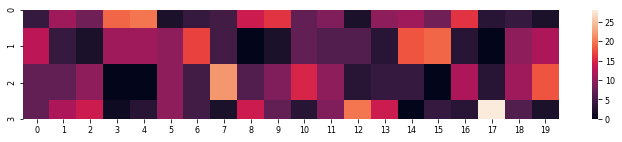

In [208]:
import seaborn as sns

ax = sns.heatmap(conf)
plt.rcParams["figure.figsize"] = (12,2)
plt.show()

In [1920]:
gini_10 = gini_coefficient(conf_10)
gini_20 = gini_coefficient(conf_20)
gini_30 = gini_coefficient(conf_30)
gini_40 = gini_coefficient(conf_40)
gini_51 = gini_coefficient(conf_51)
gini_60 = gini_coefficient(conf_60)

In [1921]:
print(sum(gini_10)/10)
print(sum(gini_20)/20)
print(sum(gini_30)/30)
print(sum(gini_40)/40)
print(sum(gini_51)/51)
print(sum(gini_60)/60)

0.6226999999999999
0.5858500000000001
0.5611333333333335
0.48672499999999974
0.4779607843137253
0.4243166666666665


In [1922]:
cidx_10 = dict()
for j in range(conf_10.shape[1]):
    cl = np.argmax(conf_10[:,j])
    cidx_10[j] = cl

cidx_20 = dict()
for j in range(conf_20.shape[1]):
    cl = np.argmax(conf_20[:,j])
    cidx_20[j] = cl

cidx_30 = dict()
for j in range(conf_30.shape[1]):
    cl = np.argmax(conf_30[:,j])
    cidx_30[j] = cl
    
cidx_40 = dict()
for j in range(conf_40.shape[1]):
    cl = np.argmax(conf_40[:,j])
    cidx_40[j] = cl

cidx_51 = dict()
for j in range(conf_51.shape[1]):
    cl = np.argmax(conf_51[:,j])
    cidx_51[j] = cl
    
cidx_60 = dict()
for j in range(conf_60.shape[1]):
    cl = np.argmax(conf_60[:,j])
    cidx_60[j] = cl    

In [1379]:
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.metrics import dtw

In [1380]:
def ba_computing(h_clus_,x_train,cidx_):
    n_instances = h_clus_.shape[0]
    n_prototypes = len(np.unique(h_clus_))
    prototypes = []
    for i in range(n_prototypes):
        digits = np.where(h_clus_ == i)[0]
        cls = cidx_[i]
        x_ = x_train[digits,:,:]
        y_ = y_train[digits]
        digits_ = np.where(y_ == cls)[0]
        ba = dtw_barycenter_averaging(x_[digits_,:,:])
        prototypes.append(ba)
    
    return np.array(prototypes)
    

In [1381]:
prototypes_10 = ba_computing(h_clus_10,x_train,cidx_10)
prototypes_20 = ba_computing(h_clus_20,x_train,cidx_20)
prototypes_30 = ba_computing(h_clus_30,x_train,cidx_30)

In [1802]:
prototypes_40 = ba_computing(h_clus_40,x_train,cidx_40)

In [1923]:
prototypes_51 = ba_computing(h_clus_51,x_train,cidx_51)
prototypes_60 = ba_computing(h_clus_60,x_train,cidx_60)

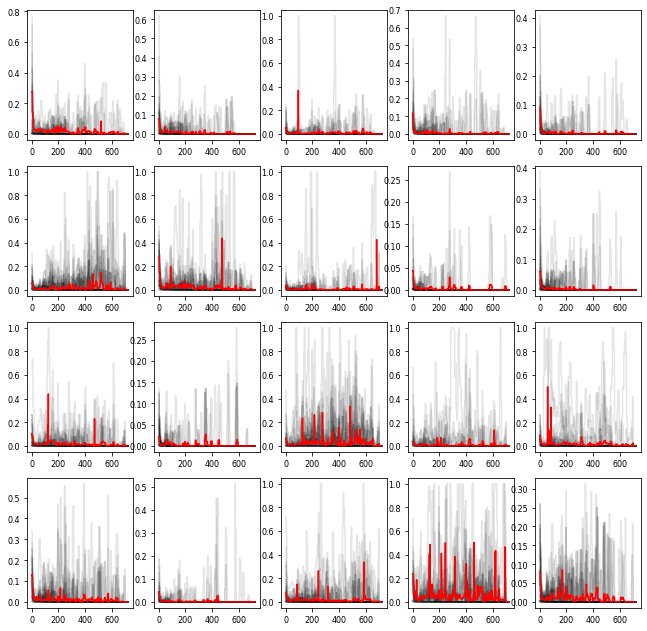

In [218]:
plt.rcParams["figure.figsize"] = (11,11)
plt.rcParams.update({'font.size': 8})
plt.figure()
for i in range(len(prototypes)):
        plt.subplot(4, 5, i+1)
        for xx in x_train[h_clus == i]:
            plt.plot(xx[:,1].ravel(), "k-", alpha=.1)
            #plt.ylim(0,1)
        plt.plot(prototypes[i][:,1].ravel(), "r-")


# Pairwise datasets

In [1924]:
def unassigned(x,y,prototypes,cidx):
    max_dis = np.inf
    arg_min = 0
    for pid in cidx.keys():
        cl = cidx[pid]
        if cl == y:
            p = prototypes[pid]
            dis = dtw(x,p)
            if dis < max_dis:
                arg_min = pid
                max_dis = dis
    
    return arg_min

In [1925]:
from random import randint

def create_pairs(x, y, prototypes, h_clus, cidx):
        pairs = [] 
        labels = []
        n_classes = np.unique(y).shape[0]
        n_prototypes = prototypes.shape[0] 
        n_instances = x.shape[0]
        for i in range(n_instances):
            pid = h_clus[i]
            cl_pr = cidx[pid]
            cl_gr = y[i]
            if cl_pr != cl_gr:
                pid = unassigned(x[i], cl_gr, prototypes, cidx)
            p = prototypes[pid]
            for pix in np.delete(np.arange(n_prototypes), pid):
                if cidx[pix] != cl_gr:
                    _p = prototypes[pix]
                    pairs += [[x[i], p]]
                    labels += [0]
                    pairs += [[x[i], _p]]
                    labels += [1]
         
        pairs, labels = shuffle(np.array(pairs), np.array(labels), random_state=0)
        
        return pairs, labels 
            

In [1385]:
tr_pairs_10, tr_y_10 = create_pairs(x_train, y_train, prototypes_10, h_clus_10, cidx_10)
tr_pairs_20, tr_y_20 = create_pairs(x_train, y_train, prototypes_20, h_clus_20, cidx_20)
tr_pairs_30, tr_y_30 = create_pairs(x_train, y_train, prototypes_30, h_clus_30, cidx_30)

In [1803]:
tr_pairs_40, tr_y_40 = create_pairs(x_train, y_train, prototypes_40, h_clus_40, cidx_40)

In [1926]:
tr_pairs_51, tr_y_51 = create_pairs(x_train, y_train, prototypes_51, h_clus_51, cidx_51)
tr_pairs_60, tr_y_60 = create_pairs(x_train, y_train, prototypes_60, h_clus_60, cidx_60)

In [1929]:
print(prototypes_10.shape[0])
print(prototypes_20.shape[0])
print(prototypes_30.shape[0])
print(prototypes_40.shape[0])
print(prototypes_51.shape[0])
print(prototypes_60.shape[0])

10
20
30
40
51
60


In [1930]:
print(tr_pairs_10.shape)
print(tr_pairs_20.shape)
print(tr_pairs_30.shape)
print(tr_pairs_40.shape)
print(tr_pairs_51.shape)
print(tr_pairs_60.shape)

(9808, 2, 72, 5)
(19620, 2, 72, 5)
(29434, 2, 72, 5)
(39246, 2, 72, 5)
(50048, 2, 72, 5)
(58894, 2, 72, 5)


In [1931]:
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda, Activation, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adadelta
from tensorflow.keras.metrics import BinaryAccuracy, CosineSimilarity, Accuracy, categorical_accuracy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model, to_categorical 
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras import backend as K

import tensorflow_addons as tfa
from tensorflow_addons.losses import contrastive_loss
from tensorflow_addons.metrics import F1Score

In [1932]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1 - y_true) * square_pred + (y_true) * margin_square)

def create_base_network(input_shape):
        input = Input(shape=input_shape)
        x = Flatten()(input)
        x = Dense(16, activation='tanh')(x)
        x = Dropout(0.1)(x)
        x = Dense(4, activation='tanh')(x)
        return Model(input, x)
    
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred != y_true)

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [1837]:
input_shape = tr_pairs_10.shape[2:]
base_network = create_base_network(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model_10 = Model([input_a, input_b], distance)
rms = RMSprop(learning_rate=0.0001)
model_10.compile(loss=contrastive_loss, optimizer=rms)

# Siamese networks

In [1838]:
model_10.summary()

Model: "model_227"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_341 (InputLayer)          [(None, 72, 5)]      0                                            
__________________________________________________________________________________________________
input_342 (InputLayer)          [(None, 72, 5)]      0                                            
__________________________________________________________________________________________________
model_226 (Model)               (None, 4)            5844        input_341[0][0]                  
                                                                 input_342[0][0]                  
__________________________________________________________________________________________________
lambda_113 (Lambda)             (None, 1)            0           model_226[1][0]          

In [1839]:
history_10 = model_10.fit([tr_pairs_10[:, 0], tr_pairs_10[:, 1]], tr_y_10, batch_size=64, epochs=50, validation_split=0.3, verbose=False)

In [1840]:
input_shape = tr_pairs_20.shape[2:]
base_network = create_base_network(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model_20 = Model([input_a, input_b], distance)
rms = RMSprop(learning_rate=0.0001)
model_20.compile(loss=contrastive_loss, optimizer=rms)
history_20 = model_20.fit([tr_pairs_20[:, 0], tr_pairs_20[:, 1]], tr_y_20, batch_size=64, epochs=50, validation_split=0.3, verbose=False)

In [1841]:
input_shape = tr_pairs_30.shape[2:]
base_network = create_base_network(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model_30 = Model([input_a, input_b], distance)
rms = RMSprop(learning_rate=0.0001)
model_30.compile(loss=contrastive_loss, optimizer=rms)
history_30 = model_30.fit([tr_pairs_30[:, 0], tr_pairs_30[:, 1]], tr_y_30, batch_size=64, epochs=50, validation_split=0.3, verbose=False)

In [1842]:
input_shape = tr_pairs_40.shape[2:]
base_network = create_base_network(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model_40 = Model([input_a, input_b], distance)
rms = RMSprop(learning_rate=0.0001)
model_40.compile(loss=contrastive_loss, optimizer=rms)
history_40 = model_40.fit([tr_pairs_40[:, 0], tr_pairs_40[:, 1]], tr_y_40, batch_size=64, epochs=50, validation_split=0.3, verbose=False)

In [1933]:
input_shape = tr_pairs_51.shape[2:]
base_network = create_base_network(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model_51 = Model([input_a, input_b], distance)
rms = RMSprop(learning_rate=0.0001)
model_51.compile(loss=contrastive_loss, optimizer=rms)
history_51 = model_51.fit([tr_pairs_51[:, 0], tr_pairs_51[:, 1]], tr_y_51, batch_size=64, epochs=50, validation_split=0.3, verbose=False)

In [1934]:
input_shape = tr_pairs_60.shape[2:]
base_network = create_base_network(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model_60 = Model([input_a, input_b], distance)
rms = RMSprop(learning_rate=0.0001)
model_60.compile(loss=contrastive_loss, optimizer=rms)
history_60 = model_60.fit([tr_pairs_60[:, 0], tr_pairs_60[:, 1]], tr_y_60, batch_size=64, epochs=50, validation_split=0.3, verbose=False)

In [1935]:
y_pred = model_60.predict([tr_pairs_60[:,0],tr_pairs_60[:,1]])
compute_accuracy(tr_y_60, y_pred)

0.8584066288586274

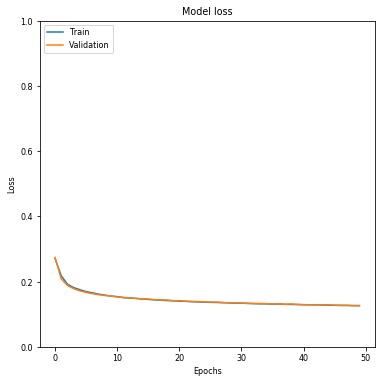

In [1844]:
plt.plot(history_40.history['loss'])
plt.plot(history_40.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim(0,1.0)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [1845]:
def get_instance(x_ins, prototypes, model_):
    n_prototypes = prototypes.shape[0]
    outcomes = np.arange(n_prototypes, dtype=float)
    for i in range(n_prototypes):
        x_test_pair = np.empty([0, 2, x_ins.shape[0], x_ins.shape[1]])
        pair = np.array([[x_ins, prototypes[i]]])
        x_test_pair = np.append(x_test_pair, pair, axis=0)
        outcomes[i] = model_.predict([x_test_pair[:, 0], x_test_pair[:, 1]])
    return outcomes

In [1846]:
tr_y_40[:10]

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1])

In [1847]:
x_test_pair = np.empty([0, 2, 72, 5])
pair = np.array([[tr_pairs_40[0,0],tr_pairs_40[0,1]]])
x_test_pair = np.append(x_test_pair, pair, axis=0)
y_pred = model_40.predict([x_test_pair[:, 0], x_test_pair[:, 1]])

In [1848]:
y_pred

array([[0.16957676]], dtype=float32)

In [1849]:
def get_bias(x_train,prototypes,model_):
    n_prototypes = prototypes.shape[0]
    n_instances = x_train.shape[0]
    outcomes = np.arange(n_instances*n_prototypes, dtype=float).reshape(n_instances,n_prototypes)
    for i in range(n_instances):
        outcomes[i,:] = get_instance(x_train[i],prototypes,model_)
    
    means = np.arange(n_prototypes, dtype=float)
    desvs = np.arange(n_prototypes, dtype=float)
    for i in range(n_prototypes):
        means[i] = np.mean(outcomes[:,i])
        desvs[i] = np.std(outcomes[:,i])
    return means, desvs, outcomes

In [1850]:
means_tr_10, desvs_tr_10, outcomes_tr_10 = get_bias(x_train,prototypes_10,model_10)
means_tr_20, desvs_tr_20, outcomes_tr_20 = get_bias(x_train,prototypes_20,model_20)
means_tr_30, desvs_tr_30, outcomes_tr_30 = get_bias(x_train,prototypes_30,model_30)
means_tr_40, desvs_tr_40, outcomes_tr_40 = get_bias(x_train,prototypes_40,model_40)

In [1936]:
means_tr_51, desvs_tr_51, outcomes_tr_51 = get_bias(x_train,prototypes_51,model_51)
means_tr_60, desvs_tr_60, outcomes_tr_60 = get_bias(x_train,prototypes_60,model_60)

In [1851]:
means_te_10, desvs_te_10, outcomes_te_10 = get_bias(x_test,prototypes_10,model_10)
means_te_20, desvs_te_20, outcomes_te_20 = get_bias(x_test,prototypes_20,model_20)
means_te_30, desvs_te_30, outcomes_te_30 = get_bias(x_test,prototypes_30,model_30)
means_te_40, desvs_te_40, outcomes_te_40 = get_bias(x_test,prototypes_40,model_40)

In [1937]:
means_te_51, desvs_te_51, outcomes_te_51 = get_bias(x_test,prototypes_51,model_51)
means_te_60, desvs_te_60, outcomes_te_60 = get_bias(x_test,prototypes_60,model_60)

In [1852]:
def get_unbias(outcomes, means):
    n_instances = outcomes.shape[0]
    n_prototypes = outcomes.shape[1]
    outcomes_ = np.arange(n_instances*n_prototypes, dtype=float).reshape(n_instances,n_prototypes)
    for i in range(n_instances):
        outcomes_[i,:] = outcomes[i,:] - means
    
    return outcomes_

In [1853]:
outcomes_tr_un_10 = get_unbias(outcomes_tr_10,means_tr_10)
outcomes_tr_un_20 = get_unbias(outcomes_tr_20,means_tr_20)
outcomes_tr_un_30 = get_unbias(outcomes_tr_30,means_tr_30)
outcomes_tr_un_40 = get_unbias(outcomes_tr_40,means_tr_40)

In [1938]:
outcomes_tr_un_51 = get_unbias(outcomes_tr_51,means_tr_51)
outcomes_tr_un_60 = get_unbias(outcomes_tr_60,means_tr_60)

In [1854]:
outcomes_te_un_10 = get_unbias(outcomes_te_10,means_tr_10)
outcomes_te_un_20 = get_unbias(outcomes_te_20,means_tr_20)
outcomes_te_un_30 = get_unbias(outcomes_te_30,means_tr_30)
outcomes_te_un_40 = get_unbias(outcomes_te_40,means_tr_40)

In [1939]:
outcomes_te_un_51 = get_unbias(outcomes_te_51,means_tr_51)
outcomes_te_un_60 = get_unbias(outcomes_te_60,means_tr_60)

# Bias and variance modeling

In [1855]:
def eval_instance(i,outcomes,y,cidx_,verbose=False):
    if verbose: 
        print("GT:",y[i])
        print("PR:",cidx_[np.argmin(outcomes[i,:])], np.argmin(outcomes[i,:]))
        print(y[i] == cidx_[np.argmin(outcomes[i,:])])
        print(outcomes[i,])
    return y[i] == cidx_[np.argmin(outcomes[i,:])]

In [1856]:
eval_instance(7,outcomes_te_un_40,y_test,cidx_40,True)

GT: 0
PR: 0 28
True
[ 0.57934168  0.53440021  0.5728901   0.67217441 -0.06603308  0.13838618
 -0.09570878  0.19998058 -0.40626819  0.49691102  0.3580664   0.67602
  0.49896348 -0.25692222 -0.58474735 -0.33655291  0.66353402  0.49451214
  0.477816    0.36861861  0.62638771  0.1680541   0.21317708  0.6440139
  0.66792542 -0.22436452  0.45618847  0.66530554 -0.61972543 -0.07252395
 -0.35169559  0.56400031  0.11267243 -0.42964491  0.66592677  0.00979138
  0.55068147  0.12155823  0.12264299 -0.15287482]


True

In [1857]:
def get_accuracy(outcomes,y,cidx_):
    accum = 0
    n_instances = outcomes.shape[0]
    for i in range(n_instances):
        val = eval_instance(i,outcomes,y,cidx_)
        if (val == True): accum += 1
            
    return accum/n_instances

In [1941]:
print(get_accuracy(outcomes_tr_un_10,y_train,cidx_10))
print(get_accuracy(outcomes_tr_un_20,y_train,cidx_20))
print(get_accuracy(outcomes_tr_un_30,y_train,cidx_30))
print(get_accuracy(outcomes_tr_un_40,y_train,cidx_40))
print(get_accuracy(outcomes_tr_un_51,y_train,cidx_51))
print(get_accuracy(outcomes_tr_un_60,y_train,cidx_60))

0.5030581039755352
0.4969418960244648
0.555045871559633
0.5519877675840978
0.5443425076452599
0.5351681957186545


In [1942]:
print(get_accuracy(outcomes_te_un_10,y_test,cidx_10))
print(get_accuracy(outcomes_te_un_20,y_test,cidx_20))
print(get_accuracy(outcomes_te_un_30,y_test,cidx_30))
print(get_accuracy(outcomes_te_un_40,y_test,cidx_40))
print(get_accuracy(outcomes_te_un_51,y_test,cidx_51))
print(get_accuracy(outcomes_te_un_60,y_test,cidx_60))

0.4573170731707317
0.4146341463414634
0.5
0.4634146341463415
0.4451219512195122
0.4878048780487805


# FFNN

In [1943]:
def get_ml_set(outcomes):
    n_instances = outcomes.shape[0]
    n_prototypes = outcomes.shape[1]
    outcomes_ = np.arange(n_instances*n_prototypes, dtype=float).reshape(n_instances,n_prototypes)
    for i in range(n_instances):
        xls = outcomes[i,:]*-1
        xls = xls - np.min(xls)
        xls = xls/np.max(xls)
        outcomes_[i,:] = xls
        
    return outcomes_

In [1944]:
outcomes_training_10 = get_ml_set(outcomes_tr_10)
outcomes_testing_10 = get_ml_set(outcomes_te_10)
outcomes_training_20 = get_ml_set(outcomes_tr_20)
outcomes_testing_20 = get_ml_set(outcomes_te_20)
outcomes_training_30 = get_ml_set(outcomes_tr_30)
outcomes_testing_30 = get_ml_set(outcomes_te_30)
outcomes_training_40 = get_ml_set(outcomes_tr_40)
outcomes_testing_40 = get_ml_set(outcomes_te_40)
outcomes_training_51 = get_ml_set(outcomes_tr_51)
outcomes_testing_51 = get_ml_set(outcomes_te_51)
outcomes_training_60 = get_ml_set(outcomes_tr_60)
outcomes_testing_60 = get_ml_set(outcomes_te_60)

In [1945]:
from sklearn.neural_network import MLPClassifier

In [1946]:
clf_10 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(32,4), random_state=1, validation_fraction=0.5, verbose=False, max_iter=1000)
clf_20 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(32,4), random_state=1, validation_fraction=0.5, verbose=False, max_iter=1000)
clf_30 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(32,4), random_state=1, validation_fraction=0.5, verbose=False, max_iter=1000)
clf_40 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(32,4), random_state=1, validation_fraction=0.5, verbose=False, max_iter=1000)
clf_51 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(32,4), random_state=1, validation_fraction=0.5, verbose=False, max_iter=1000)
clf_60 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(32,4), random_state=1, validation_fraction=0.5, verbose=False, max_iter=1000)

In [1947]:
clf_10.fit(outcomes_training_10,y_train)
clf_20.fit(outcomes_training_20,y_train)
clf_30.fit(outcomes_training_30,y_train)
clf_40.fit(outcomes_training_40,y_train)
clf_51.fit(outcomes_training_51,y_train)
clf_60.fit(outcomes_training_60,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 4), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.5, verbose=False, warm_start=False)

# Training (k=40 for Tw 16)

In [1948]:
print(clf_10.score(outcomes_training_10,y_train))
print(clf_20.score(outcomes_training_20,y_train))
print(clf_30.score(outcomes_training_30,y_train))
print(clf_40.score(outcomes_training_40,y_train))
print(clf_51.score(outcomes_training_51,y_train))
print(clf_60.score(outcomes_training_60,y_train))

0.5321100917431193
0.5336391437308868
0.5749235474006116
0.6085626911314985
0.5779816513761468
0.5856269113149847


# Testing (k=40 for Tw 16)

In [1949]:
print(clf_10.score(outcomes_testing_10,y_test))
print(clf_20.score(outcomes_testing_20,y_test))
print(clf_30.score(outcomes_testing_30,y_test))
print(clf_40.score(outcomes_testing_40,y_test))
print(clf_51.score(outcomes_testing_51,y_test))
print(clf_60.score(outcomes_testing_60,y_test))

0.49390243902439024
0.5121951219512195
0.5
0.5548780487804879
0.5060975609756098
0.5182926829268293
